In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from enum import Enum
import os

import sys
# sys.path.append( '/content/drive/My Drive/thesis-workspace' ) # drive version
sys.path.append( '../../src/' ) # local version

from ml.preprocessing import *

# Classification

## Loading Datasets

In [3]:
class DF( Enum ):
    _10SEC = 'home-10sec'
    _10SEC_AVG = 'home-10sec-avg'
    _30SEC = 'home-30sec'
    _30SEC_AVG = 'home-30sec-avg'
    _1MIN = 'home-1min'
    _1MIN_AVG = 'home-1min-avg'
    _5MIN = 'home-5min'
    _5MIN_AVG = 'home-5min-avg'
    
# path = [ '.', 'drive', 'My Drive', 'thesis-workspace', 'datasets' ]
path = [ '..', '..', 'datasets', 'resolutions' ]

df = {}
for k in DF :
    temp = [ None ] * 2
    temp[ 0 ] = pd.read_csv( os.path.join( *path, 'ds-%s-train.csv' % k.value ), index_col = 'date', parse_dates = [ 'date' ] )
    temp[ 1 ] = pd.read_csv( os.path.join( *path, 'ds-%s-test.csv' % k.value ), index_col = 'date', parse_dates = [ 'date' ] )
    df[ k ] = temp

## Data splitting, standarization and balancing

In [4]:
from imblearn.over_sampling import ADASYN
from collections import Counter


# Number of neighbors to use for balancing each dataset

neighbors = { 
    DF._10SEC: 1,
    DF._10SEC_AVG: 1,
    DF._30SEC: 1,
    DF._30SEC_AVG: 1,
    DF._1MIN: 1,
    DF._1MIN_AVG: 1,
    DF._5MIN: 1,
    DF._5MIN_AVG: 1
}

for k, d in df.items():
    temp = [ 
        d[ 0 ].drop( 'occ', axis = 1 ), # x train
        d[ 1 ].drop( 'occ', axis = 1 ), # x test
        d[ 0 ].occ, # y train
        d[ 1 ].occ ] # y test
    
    temp[ X_TRAIN ], temp[ X_TEST ] = standardize( temp[ X_TRAIN ], temp[ X_TEST ] )

    print( 'Before balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    temp[ X_TRAIN ], temp[ Y_TRAIN ] = balance_df( 
        temp[ X_TRAIN ],
        temp[ Y_TRAIN ],
        neighbors[ k ] )
    print( 'After balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    print()
    
    df[ k ] = temp

Before balancing: DF._10SEC Counter({'L': 16325, 'E': 4098, 'M': 2830, 'H': 547})
After balancing: DF._10SEC Counter({'E': 16353, 'M': 16330, 'H': 16329, 'L': 16325})

Before balancing: DF._10SEC_AVG Counter({'L': 16325, 'E': 4098, 'M': 2830, 'H': 547})
After balancing: DF._10SEC_AVG Counter({'M': 16354, 'L': 16325, 'H': 16325, 'E': 16318})

Before balancing: DF._30SEC Counter({'L': 5450, 'E': 1345, 'M': 956, 'H': 188})
After balancing: DF._30SEC Counter({'H': 5452, 'L': 5450, 'E': 5445, 'M': 5436})

Before balancing: DF._30SEC_AVG Counter({'L': 5450, 'E': 1345, 'M': 956, 'H': 188})
After balancing: DF._30SEC_AVG Counter({'M': 5468, 'E': 5463, 'L': 5450, 'H': 5448})

Before balancing: DF._1MIN Counter({'L': 2730, 'E': 673, 'M': 480, 'H': 92})
After balancing: DF._1MIN Counter({'H': 2732, 'L': 2730, 'M': 2720, 'E': 2720})

Before balancing: DF._1MIN_AVG Counter({'L': 2730, 'E': 673, 'M': 480, 'H': 92})
After balancing: DF._1MIN_AVG Counter({'M': 2742, 'H': 2731, 'L': 2730, 'E': 2730})



## Training

In [5]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from ml.classification import *

params_knn = [ { 
    'n_neighbors': [ 1, 3, 5 ], 
    'p': [ 2 ], # mikowsky distance = euclidian distance
    'algorithm': [ 'ball_tree', 'kd_tree' ] # removed brute force due to the dataset size
} ]

grids = { 
    DF._10SEC: None,
    DF._10SEC_AVG: None,
    DF._30SEC: None,
    DF._30SEC_AVG: None,
    DF._1MIN: None,
    DF._1MIN_AVG: None
}

labels = [ 'E', 'H', 'L', 'M' ]
exclude = [  ]

### Regular

Dataset  DF._10SEC 4
Best params:  {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2}
Training Accuracy 0.996441523307779
Test Accuracy:  0.9848764913459923
Test ROCauc (OvR): 0.9799721407511317

Detailed Classification Report
              precision    recall  f1-score   support

           E       0.98      0.98      0.98      1029
           H       0.98      0.93      0.95       141
           L       0.99      0.99      0.99      4050
           M       0.96      0.97      0.97       731

    accuracy                           0.98      5951
   macro avg       0.98      0.97      0.97      5951
weighted avg       0.98      0.98      0.98      5951


Dataset  DF._10SEC_AVG 4
Best params:  {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2}
Training Accuracy 0.9968655415747115
Test Accuracy:  0.9882372710468829
Test ROCauc (OvR): 0.9857412413131713

Detailed Classification Report
              precision    recall  f1-score   support

           E       0.99      0.99      0.99   

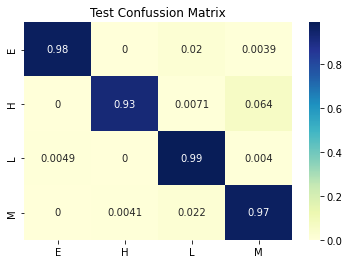

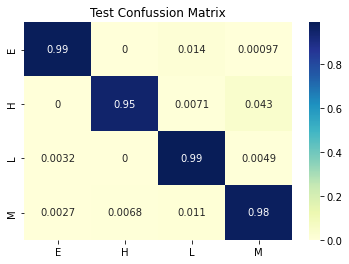

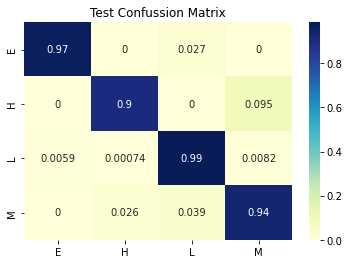

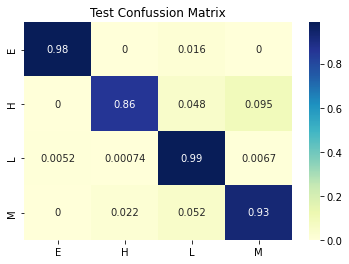

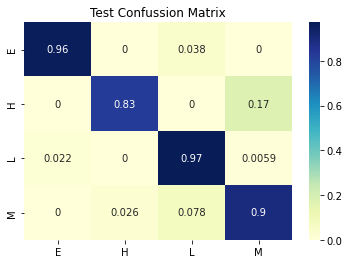

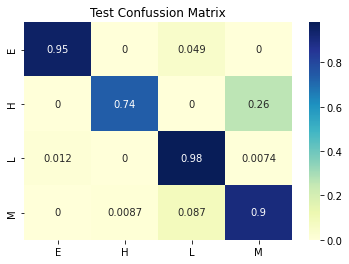

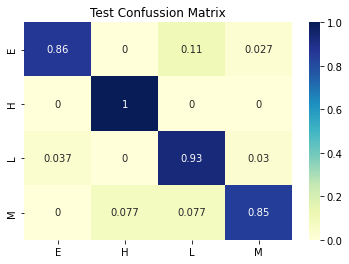

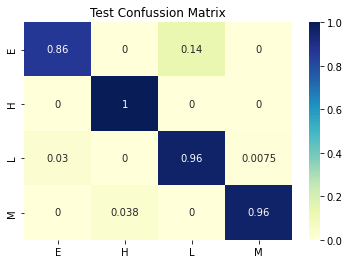

In [6]:
%%time
for k, d in df.items():
    if( k not in exclude ):
        print( 'Dataset ', k, len( d ) )
        grids[ k ] = train_and_test( 
                KNeighborsClassifier(), params_knn, 
                d[ X_TRAIN ], d[ Y_TRAIN ], 
                d[ X_TEST ], d[ Y_TEST ], 
                plot_cmatrix = True, labels = labels  )

# Evaluation

In [7]:
from ml.evaluation import *

## Learning Curves

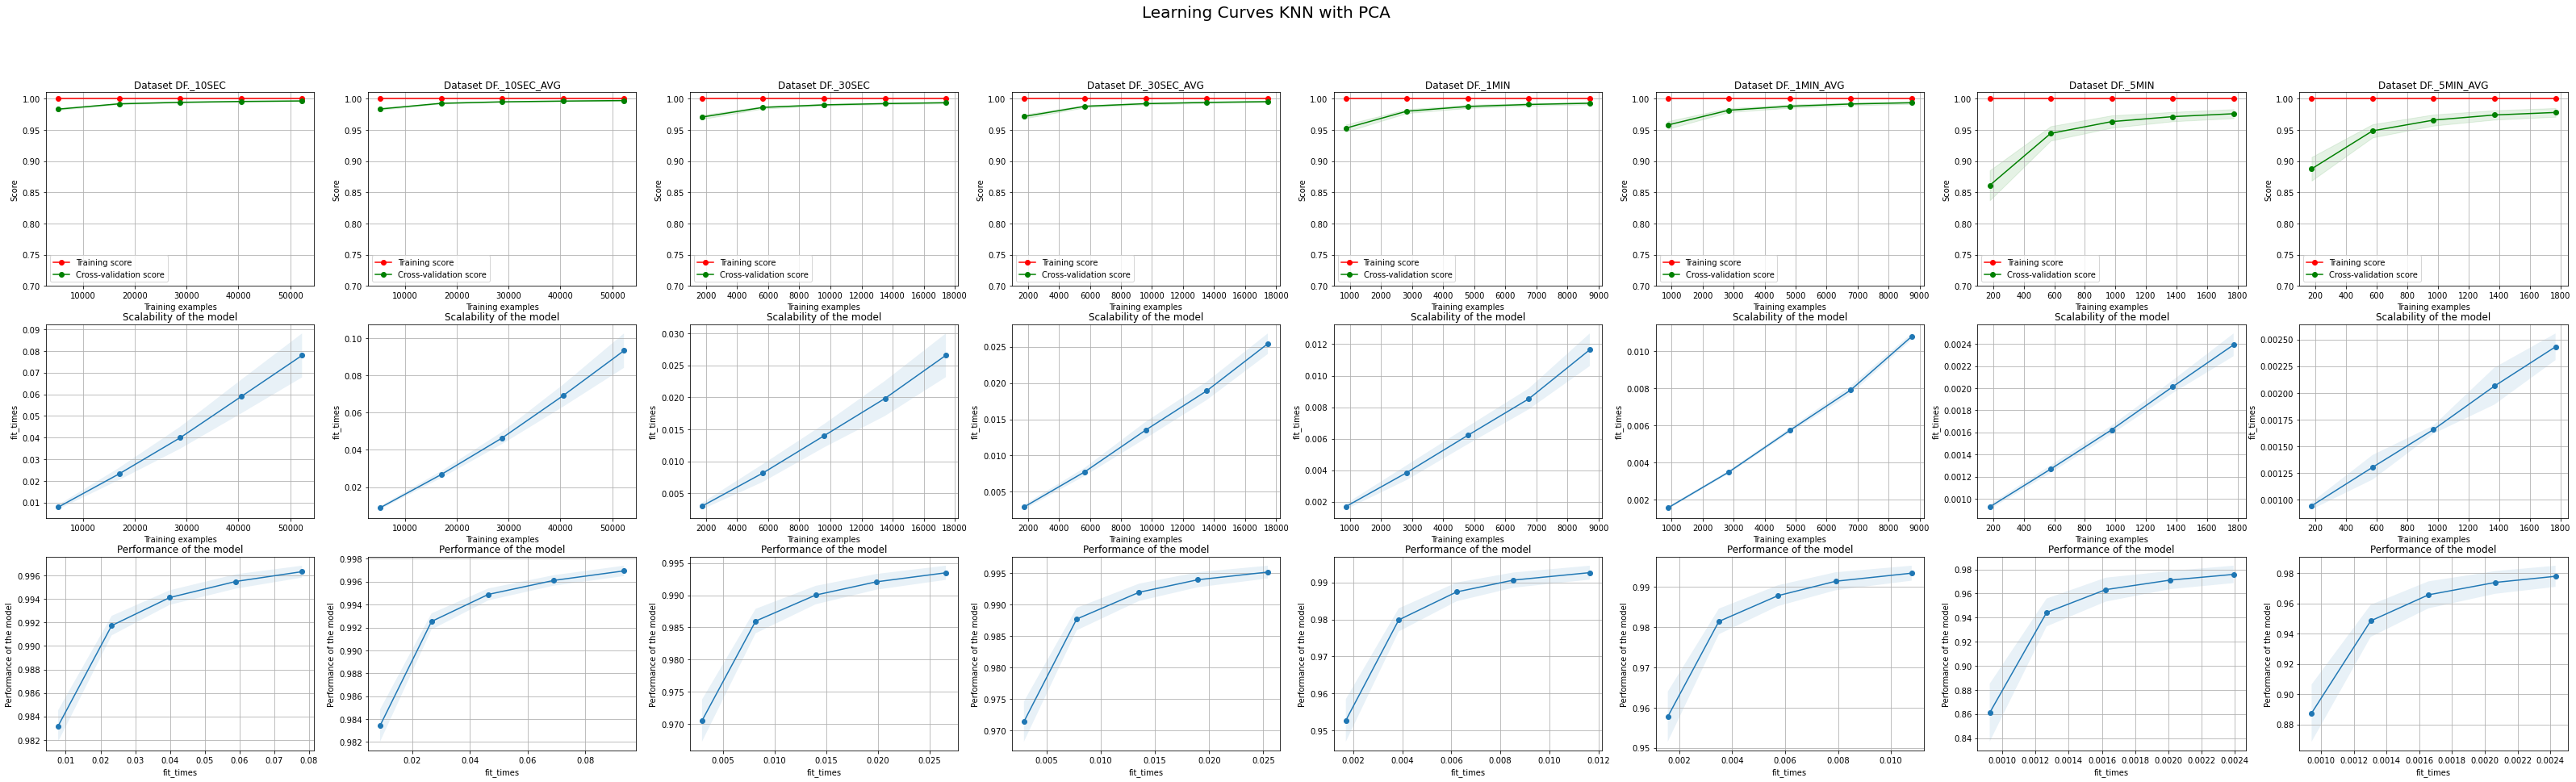

CPU times: user 19.5 s, sys: 950 ms, total: 20.4 s
Wall time: 10min 59s


In [8]:
%%time
temp = [ item for item in df.items() if item[ 0 ] not in [] ]
plot_learning_curves( temp, grids, 'KNN' )